In [47]:
# importing packages

import pandas as pd
from scipy.optimize import minimize
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.6f}'.format
plt.style.use('seaborn')
np.random.seed(300)
%matplotlib inline

#use python -m pip install (package name) to install any missing packages above.  

By Nicholas Millar (11218854) and Edward Mckenzie (24542173)

***Examining the Impact of Covariance Matrix Shrinkage Techniques on Optimisation Algortihms***

This project aims to explore the efficacy of various optimisation algortihms when conducting portfolio ptimisation under two scenarios: 

1. Where the estimated covariance of stock returns is singular/non-invertible
2. Where the estimated covariance of stock returns has been shrunk using the Ledoit Wolfe methodology, resulting in a nonsinuglar and invertible covariance matrix

This analysis is based off the paper written by Olivier Ledoit and Michael Wolfe (which can be dound here: http://www.ledoit.net/honey.pdf)

The central argument of the paper is that using the sample covariance of stock returns often leads to significant estimation error in the extreme values of the matrix, leading to a covariance matrix which is no longer positive definite and therefore resulting in problematic results for any mean-variance optimiser.

Ledoit and Wolfe proposed a way of fixing this extreme value error by forming a new covariance matrix which is a weighted average of the sample covariance matrix and a highly structured estimate. The structured model used by Ledoit and Wolfe is a constant correlation model which assumes all pairwise correlations are identical. By combining these two estimators the resulting matrix is a compromise between the two which pulls the incorrect extreme values from the original matrix towards the centre.

The end result is a covariance matrix which results in a smaller tracking error relative to the benchmark when compared to the original covariance matrix. This is important for active portfolio managers as it implies they are achieving the same returns for a lower portfolio variance, this is a positive for various metrics which PM's are assessed on such as Sharpe ratio and Information Ratio.

This research will focus more on solving the constrained non-linear optimisation problem via different algorithms and will show how the different algorithms perform when trying to find the global solution under the two scenarios described above.

**Setting Up the Problem**


Our minimisation problem is of the form:

Minimise: $$x'\Sigma x$$ 
Subject to: $$x'\alpha \geq g \\
            x'1 = 0 \\
            x \geq -w_B \\
            x \leq c1 - w_B$$
            
Where: $$w_B = \text{vector of benchmark weights for the univers of N Stocks} \\
        x = \text{vector of active weights} \\
        \mu = \text{vector of expected stock returns} \\
        \alpha = \mu - w_B\mu = \text{vector of expected excess returns} \\
        \Sigma = \text{covariance matrix}$$
        

We can see from the formulation of our minimisation problem that we have a quadratic objective function with linear/affine constriants. This means that the minimisation is a convex optimisation problem, conditional on the covariance matrix being positive definite. 

Dealing with convex optimisation problems is ideal as the local solution of the function is also the global solution and there are many efficient and accurate algorithms which can solve convex problems. 

Finding the global solution in our case is important as it represents the optimal set of weights which minimises the variance/tracking error for a given return limit, when dealing with large notional size portfolios small changes in the weight vector can lead to portfolio losses in the millions to hundreds of millions.

The following code parses and cleans the data so the variables and minimisation problem is set up correctly for further analysis:

In [48]:
# important functions

# function to check if matrix is positive definite
def is_pos_def(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)

#  function to add a random normal value to each row. This is required to estimate the excess return
def add_random_normal(row):
    return row + np.random.normal(0, 1) / 100

# Objective function is to minimise the tracking error variance of the portfolio. Active weight of portfolio 
# (transposed) dot product with covariance matrix and dot product of active weights
def objective_f(x, cov_matrix):
    return x.T @ cov_matrix @ x

# Callback function to record the optimization path - estimated covariance
def record_history_estimate_cov(x):
    obj_f_history.append(objective_f(x, estimate_cov))
    df = pd.DataFrame({'% Wgt': sp_weights['% Wgt'] + x})
    history_weights.append(df)
    
# Callback function to record the optimization path - shrunk matrix
def record_history_shrunk_cov(x):
    obj_f_history.append(objective_f(x, shrink_cov))
    df = pd.DataFrame({'% Wgt': sp_weights['% Wgt'] + x})
    history_weights.append(df)


In [49]:
# constants
g = 0.03 # manager tracking alpha
upper_bound = 0.1  # stock ownership upper bound (c). Cannot own more than 10% in any 1 stock

#month to analyse
month = '2023-03-31'

#number of monthly returns
num_monthly_returns = 60


In [50]:
# Getting S&p 500 stock weight data

# clean up dataframe drop all columns and rows where every value is Nan

sp_weights = pd.read_csv("sp_weights.csv")

sp_weights['Effective Date'] = pd.to_datetime(sp_weights['Effective Date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

#filtering weights for March 2023
sp_weights = sp_weights[sp_weights['Effective Date'] == month]

sp_weights.set_index('Ticker', inplace=True)

sp_weights['% Wgt'] = sp_weights['% Wgt'] / 100

sp_weights = sp_weights[['% Wgt']]

sp_weights = sp_weights[sp_weights['% Wgt'] != 0].dropna()

#keep top n stocks by weight
sp_weights = sp_weights.nlargest(100, '% Wgt')


In [51]:
# getting stock price data
sp_prices = pd.read_csv("sp_prices_monthly.csv")

sp_prices['Effective Date'] = pd.to_datetime((sp_prices)['Effective Date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

sp_prices.set_index('Effective Date', inplace=True)

# clean up dataframe drop all columns and rows where every value is Nan
sp_returns = (sp_prices / sp_prices.shift()) - 1

sp_returns = sp_returns.dropna(axis=0, how='all')
sp_returns = sp_returns.dropna(axis=1, how='all')
sp_returns = sp_returns.fillna(0)

# Drop columns in s&p stock returns that don't exist in the index of s&p stock weights
columns_to_drop = list(set(sp_returns.columns) - set(sp_weights.index))

sp_returns = sp_returns.drop(columns_to_drop, axis=1)

sp_returns = sp_returns.tail(num_monthly_returns)

# Drop columns in s&p stock weights that don't exist in the s&p rteturns
rows_to_drop = list(set(sp_weights.index) - set(sp_returns.columns))

sp_weights = sp_weights.drop(rows_to_drop, axis=0)

#total weight of remaining stocks
total_bench_weight = np.sum(sp_weights['% Wgt'])

# Divide each row value by its corresponding column sum - this is to reweight remaining stocks by total weight of remainder.
for index, row in sp_weights.iterrows():
    sp_weights.loc[index] = row['% Wgt'] / total_bench_weight

bench_weights_array = sp_weights['% Wgt'].to_numpy()


In [52]:
#Initial selected S&P 500 benchmark weights 
sp_weights

,% Wgt
Ticker,
AAPL US,0.105528
MSFT US,0.092337
AMZN US,0.039573
NVDA US,0.029346
GOOGL US,0.026530
...,...
CB US,0.003409
SCHW US,0.003409
DUK US,0.003261


In [53]:
# getting S&p 500 benchmark monthly returns

sp_benchmark_returns = pd.read_csv("sp_benchmark_returns.csv")

sp_benchmark_returns['Date'] = pd.to_datetime(sp_benchmark_returns['Date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

sp_benchmark_returns.set_index('Date', inplace=True)

sp_benchmark_returns = sp_benchmark_returns[['% Change']]

sp_benchmark_returns = sp_benchmark_returns.dropna(axis=0, how='all')

benchmark_return = sp_benchmark_returns['% Change'].loc[month]

In [54]:
#Preparing excess return estimations

stock_returns_march = sp_returns.loc[month]
excess_return = stock_returns_march - benchmark_return

alpha = excess_return.apply(lambda y: add_random_normal(y))


**The Issue With the Estimated Sample Covariance Matrix**

The sample covariance matrix is easy to compute via the following forumla: $\mathbf{\Sigma} = \mathbf{E}(r-\mu)(r-\mu)^T$ and has the property of being unbiased (i.e its expected value is equal to the true covariance matrix). Unfortunately it contains a lot of estimation error when the number of assets N is large relative to the number of time periods T. This occurs frequently in portfolio optimisation as the time frame is usually truncated to 1 or 2 years to account for different market regimes, stocks moving in/out of the index etc. but there is no reason to limit the number of stocks available to the portfolio manager. The end result is $N \geq T$ and the columns of our matrix is significantly larger than the number of rows, creating a singular matrix.

A singular matrix leads to numerical instability  and large estimation errors, it also means the above minimisation problem is no longer convex. This causes a variety of issues when trying to implement the minimisation process and small changes in the input data e.g returns leads to significant differences in the estimated covariance matrix.

We can show the effect of an increasing N by calculating the condition number $\kappa$ for our estimated matrix: 

\begin{align}
\kappa(\Sigma) \ = \  \|\Sigma \| \|\Sigma^{-1}\| \:,
\end{align}

where $\|\cdot\|$ is the _Euclidean norm_, $\|x\| \ = \ (\sum_i x_i^2)^{1/2}$.

If $\mathbf{\Sigma}$ is singular, $\kappa = \infty \:$



 Final Condition number: 3.3564891505879347e+19


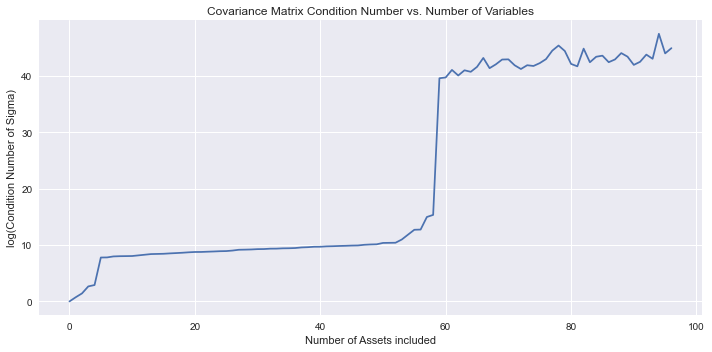

In [55]:
kappa = []
for i in range(1, sp_returns.shape[1]):
    kappa.append(np.linalg.cond(sp_returns.iloc[:,:i].cov().values))    
    
plt.figure(figsize=(10,5))
plt.plot(range(len(kappa)), np.log(kappa));
plt.title('Covariance Matrix Condition Number vs. Number of Variables')
plt.xlabel('Number of Assets included')
plt.ylabel('log(Condition Number of Sigma)')
plt.tight_layout();

print(f" Final Condition number: {kappa[-1]}")

We can see by the graph that as we increase the number of stocks N the condition number of the covariance matrix increases rapidly, with the final condition number being: $n=98$ : $\kappa \approx 3.02056 \times 10^{18}$

We can also use the definition of a positive semidefinite matrix to check our results. A matrix is positive-semidefinite if: 

\begin{align}
\mathbf{x}^T \mathbf{\Sigma}\mathbf{x}\geq 0, \qquad \forall \mathbf{x} \in \mathbb{R}^{n}
\end{align}

This implies that the eigenvalues a greater than or equal to zero. We have defined a function below which checks if the eigenvalues satisfy this condition:

In [56]:
#Calculating the covariance estimate matrix 
estimate_cov = np.cov(sp_returns, rowvar=False)

# function to check if matrix is positive definite
def is_pos_def(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)

# showing that the matrix is not positive definite
print(is_pos_def(estimate_cov))


False


To reiterate, the fundamental issue with a singular matrix, and therefore a non-convex optimisation problem, is that we cannot guarantee the local solution of our optimisation is also the global solution. The end result will be highly dependent on our starting vector of weights, this can create issues for a portfolio manager looking to rebalance their portfolio in successive intervals e.g monthly where the starting weight vector at each month will be different. Therefore, to avoid spurious results, the algorithm must be capable of finding the global solution even in non-convex scenarios or the problem needs to be reformulated to a convex one.

Below we will show the impact of choosing various starting weights on the final solution of the optimisation problem. The algorithms used are SLSQP, ECOS, and OSQP:

* SLSQP:
    1. The SLSQP algorthm begins by using the current point/vector and forming a Least Squares subproblem of the objective function as well as linear approximations of the constraints
    2. The algorithm then attempts to solve the the least squares subproblem using first order gradient information to find an improving search direction which also satisfies the constraints
    3. Line search is then performed at each iteration to determine the step length
    4. The next point is updated by the algorithm by moving in the direction and length calcualted above
    5. Convergence is then checked at each iteration
    
    
* ECOS:
    1. The ECOS starts by reformulating the QP problem to a SOCP problem
    2. The algorithm then initializes the primal, dual and slack variables which will be adjusted interatively to result in convergence
    3. The ECOS method then uses an interior point algorithm combined with predictor-corrector steps to update the variables
    4. Convergence is then checked at each iteration
    
    
* OSQP:
    1. The OSQP algorithm begins by reformulating the QP problem into its augmented Lagrangian form
    2. The algorthm then uses the ADMM (Alternating Direction Method of Multipliers) technique to solve the augmented lagrangian problem iteratively
    3. At each iteration the dual variable associated with the linear constraints is updated by solving a convex subproblem using a gradient algorithm, the primal variables are updated by a solving a seperate quadratic subproblem at each iteration
    4. Residuals are then calculated by the difference between the current and the calculated optimal solution
    5. Convergence is achieved once the residuals reach a sufficiently small value

In [57]:
#arrays required for optimisation
x_list = []

x_weight_bounds = [0, 0.05, 0.10]

for i in x_weight_bounds:
    # generate a list of n random numbers between -1 and 1
    x = np.random.uniform(low=-i, high=i, size=len(sp_weights))

    # adjust the numbers to make them sum to 0
    x -= x.sum() / len(sp_weights)

    #Generate active weights first setting all active weights as 0 i.e. 
    #our stock weight equal to benchmark weight but then also generate random
    #active weights keeping in mind that the sum of active weights must equal to 0. 
    x_list.append(x)

# c is array of upper bound limits
c = np.repeat(upper_bound, len(sp_weights))

ones = np.repeat(1, len(sp_weights))


In [58]:
#Performing optimisation problem on non positive definite matrix

#Constraints for scipy 
constraint_one = dict(type='ineq', fun=lambda x: x.T @ alpha - g)
constraint_two = dict(type='eq', fun=lambda x: np.sum(x))
constraint_three = dict(type='ineq', fun=lambda x: - x + (c * ones - bench_weights_array))
constraint_four = dict(type='ineq', fun=lambda x: x.T + bench_weights_array)


In [59]:
iter_obj_hist = []
iter_step_weights = []
final_portfolio_weight = []
active_weights_lst = []


for x in x_list:
    # Store optimization history
    obj_f_history = []
    history_weights = []
    
    #scipy minimise using SLSQP method
    opts = minimize(objective_f, x0=x, method='SLSQP',
                    constraints=[constraint_one, constraint_two, constraint_three, constraint_four], 
                    args=(estimate_cov), callback=record_history_estimate_cov)

    if opts['message'] != 'Optimization terminated successfully.':
        print(opts['message'])

    active_weights = opts.x
    
    #storing active weights 
    active_weights_lst.append(active_weights)
    
    #this is storing the objective function value from each step of the minimiser for each starting active weight
    iter_obj_hist.append(obj_f_history)
    
    #this is storing the portfolio weights value from each step of the minimiser for each starting active weight
    iter_step_weights.append(history_weights)
    
    #this is storing the final determined portfolio weights for each starting active weight
    final_portfolio_weight.append(pd.DataFrame({'% Wgt': sp_weights['% Wgt'] + active_weights}))

print(final_portfolio_weight)

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
[            % Wgt
Ticker           
AAPL US  0.097139
MSFT US  0.093608
AMZN US  0.045132
NVDA US  0.033931
GOOGL US 0.033572
...           ...
CB US    0.005821
SCHW US  0.001806
DUK US   0.003762
SO US    0.003579
TGT US   0.000000

[98 rows x 1 columns],             % Wgt
Ticker           
AAPL US  0.092960
MSFT US  0.089686
AMZN US  0.071887
NVDA US  0.031852
GOOGL US 0.017212
...           ...
CB US    0.004557
SCHW US  0.001337
DUK US   0.000527
SO US    0.010363
TGT US   0.000000

[98 rows x 1 columns],             % Wgt
Ticker           
AAPL US  0.010578
MSFT US  0.054501
AMZN US  0.002646
NVDA US  0.035905
GOOGL US 0.001163
...           ...
CB US    0.000829
SCHW US  0.000190
DUK US   0.001216
SO US    0.016280
TGT US   0.000260

[98 rows x 1 columns]]


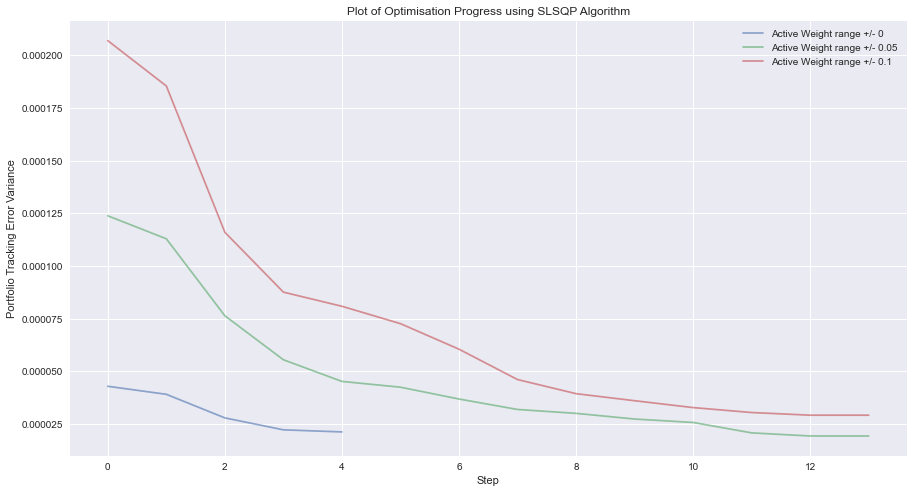

In [60]:
# Assuming history_weights is your list of lists
plt.figure(figsize=(15, 8))  # Increase size of figure as needed
plt.title('Plot of Optimisation Progress using SLSQP Algorithm')
plt.xlabel('Step')
plt.ylabel('Portfolio Tracking Error Variance')

for i, sublist in enumerate(iter_obj_hist):
    plt.plot(range(len(sublist)), sublist, alpha=0.6, label='Active Weight range +/- ' + str(x_weight_bounds[i]))
    
plt.legend()
plt.show()



In [61]:
for i, weights in enumerate(active_weights_lst):

    #Derived stock weights for our portfolio from scipy minimise on estimated covariance. 
    tracking_error_variance = weights.T @ estimate_cov @ weights

    print("Resulting minimised tracking error variance for " + str(x_weight_bounds[i]) + " is: " + "{:.6f}".format(tracking_error_variance))


Resulting minimised tracking error variance for 0 is: 0.000021
Resulting minimised tracking error variance for 0.05 is: 0.000019
Resulting minimised tracking error variance for 0.1 is: 0.000029


**SLSQP for a Non-Convex Objective Function**

As we can see from the results above, the SLSQP algorithm is heavily impacted by differences in the starting weight vector. This is not surprising since the SLSQP algorithm is a gradinet based algorithm which uses the calculated gradients of a quadratic subproblem at each iteration in order to determine the direction and line search of the next step. This means that for a non-convex problem such as the one above the SLSQP algorithm is likely to get stuck at the local minima closest to the starting point and will not converge to the global minimum easily, this is evident in the range of final values provided for each starting vector.

Below we use the CVXPY two solvers on our optimisation problem containing the original estimated covariance matrix:

In [64]:
#USING cvxpy and estimated covariance matrix
# Define the optimization variable
x = cp.Variable(x.shape[0])
# Define the objective function
objective = cp.quad_form(x, estimate_cov)

# Define the constraints
constraint_one_cvxpy = x.T @ alpha - g >= 0
constraint_two_cvxpy = cp.sum(x) == 0
constraint_three_cvxpy = -x + (c * ones - bench_weights_array) >= 0
constraint_four_cvxpy = x.T + bench_weights_array >= 0

# Solve using different solvers
solvers = [cp.ECOS, cp.OSQP]

In [65]:
for i,initial_x in enumerate(x_list):
    print("Solving for " + str(x_weight_bounds[i]))
    print("")
    for solver in solvers:
        problem = cp.Problem(cp.Minimize(objective),
                         [constraint_one_cvxpy, constraint_two_cvxpy, constraint_three_cvxpy, constraint_four_cvxpy])
        problem.solve(solver=solver)

        print("Solver:", solver)
        active_weights = x.value
        portfolio_weights = pd.DataFrame(sp_weights['% Wgt'] + active_weights,columns=['% Wgt'])
        portfolio_weights['% Wgt'] = round(portfolio_weights['% Wgt'], 4)
        tracking_error_variance = active_weights.T @ estimate_cov @ active_weights
        print(portfolio_weights)
        print("Resulting minimised tracking error variance is: " + "{:.6f}".format(tracking_error_variance))
        print("\n")


Solving for 0

Solver: ECOS
            % Wgt
Ticker           
AAPL US  0.044300
MSFT US  0.077600
AMZN US  0.013800
NVDA US  0.041100
GOOGL US 0.089900
...           ...
CB US    0.003600
SCHW US  0.000000
DUK US   0.000000
SO US    0.009000
TGT US   0.000000

[98 rows x 1 columns]
Resulting minimised tracking error variance is: 0.000010


Solver: OSQP
             % Wgt
Ticker            
AAPL US   0.065500
MSFT US   0.082500
AMZN US   0.027400
NVDA US   0.038000
GOOGL US  0.071700
...            ...
CB US    -0.000000
SCHW US  -0.000000
DUK US   -0.000000
SO US     0.005000
TGT US    0.000000

[98 rows x 1 columns]
Resulting minimised tracking error variance is: 0.000010


Solving for 0.05

Solver: ECOS
            % Wgt
Ticker           
AAPL US  0.044300
MSFT US  0.077600
AMZN US  0.013800
NVDA US  0.041100
GOOGL US 0.089900
...           ...
CB US    0.003600
SCHW US  0.000000
DUK US   0.000000
SO US    0.009000
TGT US   0.000000

[98 rows x 1 columns]
Resulting minimised tracki

Interestingly we can see that both the ECOS and OSQP methods are relatively robust to changes in the starting weight vector, however they are resulting in different final solutions depending on the algorithm chosen. This is potentially explained by the different methods used by each algorithm to find a result. There appears to be two separate global solutions for the non-convex problem as both methods acheived the same minimum tracking error with different portfolio compositions. 

This poses an additional problem for the portfolio manager as these portfolios are constructed off of backwards looking data and need to perform over future periods. The different set of weights will result in a divergence of performance for the two portfolios and there is no way for the PM to discern which is better. 

**Shrinking the Covariance Matrix**

The LedoitWolfe Covariance estimator is a linear combination of the estimated covariance matrix and a constant correlation model of the covariance matrix where all pairwaise correlations between returns are identical. This can be seen by the formula below:

$$ \Sigma_{Shrink} = \delta F + (1 - \delta)\Sigma $$

Where $F$ is our constant correlation estimate and $\delta$ is our shrinkage constant which ranges from 0 - 1. 

There is an optimal value of $\delta$ which minimizes the expected distance between the shrunk covariance matrix and the true covariance matrix, the calculation of this optimal value is presented in the appendix of the white paper and implemented in python for later use below:

In [66]:
#This code is used to calculate shrinkage esimate of covariance matrix and is an extension of the work done by WLM1ke:
#https://github.com/WLM1ke/LedoitWolf/blob/master/ledoit_wolf.py
# Methodology derived from the white paper http://www.ledoit.net/honey.pdf

def shrinkage(returns):

    #checking if the input is a numpy array. If not conver it to one.
    if not isinstance(returns, np.ndarray):
        returns = returns.to_numpy()

    #here we are calcualting the sample covariance matrix
    t, n = returns.shape #getting the shape of the numpy array
    mean_returns = np.mean(returns, axis=0, keepdims=True) #getting the mean of each return column
    returns -= mean_returns #subtracting each row from the mean of that column
    sample_cov = returns.T @ returns / t #calcualting covariance of returns

    # sample average correlation
    var = np.diag(sample_cov).reshape(-1, 1) #getting the variances along the diagonals and transposing
    sqrt_var = np.sqrt(var) #standard deviation
    unit_cor_var = sqrt_var @ sqrt_var.T
    average_cor = ((sample_cov / unit_cor_var).sum() - n) / n / (n - 1)
    samp_corr_matrix = average_cor * unit_cor_var #correlation matrix
    np.fill_diagonal(samp_corr_matrix, var)

    # pi-hat
    y = returns ** 2
    phi_mat = (y.T @ y) / t - sample_cov ** 2
    phi = phi_mat.sum()

    # rho-hat
    theta_mat = ((returns ** 3).T @ returns) / t - var * sample_cov
    np.fill_diagonal(theta_mat, 0)
    rho = (
        np.diag(phi_mat).sum()
        + average_cor * (1 / sqrt_var @ sqrt_var.T * theta_mat).sum()
    )

    # gamma-hat
    gamma = np.linalg.norm(sample_cov - samp_corr_matrix, "fro") ** 2

    # shrinkage constant
    kappa = (phi - rho) / gamma
    shrink_intensity = max(0, min(1, kappa / t))

    # estimator
    sigma = shrink_intensity * samp_corr_matrix + (1 - shrink_intensity) * sample_cov

    return sigma


In [67]:
#Using SCIPY on Shrunk Covariance Matrix
# now applying the shrinkage to our returns matrix and calculating a covariance matrix
shrink_cov = shrinkage(sp_returns)

# showing that the matrix is positive definite
print(is_pos_def(shrink_cov))


True


The result of shrinking the estimated covariance matrix using the Ledoit-Wolfe methodolgy is a positive definite covariance matrix which in turn creates a convex optimization problem. Applying the same methods as before with the updated covariance matrix should result in more consistent portfolio weights across algortihms. Below we run the same optimisation processes with the shrunk matrix:

In [69]:
# running optimisation on shrunk covariance matrix
iter_obj_hist = []
iter_step_weights = []
final_portfolio_weight = []
active_weights_lst = []

for x in x_list:
    # Store optimization history
    obj_f_history = []
    history_weights = []

    opts = minimize(objective_f, x0=x, method='SLSQP',
                    constraints=[constraint_one, constraint_two, constraint_three, constraint_four], 
                    args=(shrink_cov), callback=record_history_shrunk_cov)

    if opts['message'] != 'Optimization terminated successfully.':
         print(opts['message'])

    active_weights = opts.x
    
    #storing active weights 
    active_weights_lst.append(active_weights)

    #this is storing the objective function value from each step of the minimiser for each starting active weight
    iter_obj_hist.append(obj_f_history)
    
    #this is storing the portfolio weights value from each step of the minimiser for each starting active weight
    iter_step_weights.append(history_weights)
    
    #this is storing the final determined portfolio weights for each starting active weight
    final_portfolio_weight.append(pd.DataFrame({'% Wgt': sp_weights['% Wgt'] + active_weights}))
    
print(final_portfolio_weight)


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
[             % Wgt
Ticker            
AAPL US   0.098095
MSFT US   0.093295
AMZN US   0.045649
NVDA US   0.032620
GOOGL US  0.033759
...            ...
CB US     0.005888
SCHW US   0.002119
DUK US    0.003887
SO US     0.002944
TGT US   -0.000000

[98 rows x 1 columns],             % Wgt
Ticker           
AAPL US  0.089968
MSFT US  0.088044
AMZN US  0.059419
NVDA US  0.032318
GOOGL US 0.024588
...           ...
CB US    0.004360
SCHW US  0.000163
DUK US   0.000102
SO US    0.009007
TGT US   0.000000

[98 rows x 1 columns],             % Wgt
Ticker           
AAPL US  0.032516
MSFT US  0.074711
AMZN US  0.033382
NVDA US  0.027946
GOOGL US 0.019284
...           ...
CB US    0.002630
SCHW US  0.002813
DUK US   0.003147
SO US    0.011182
TGT US   0.002578

[98 rows x 1 columns]]


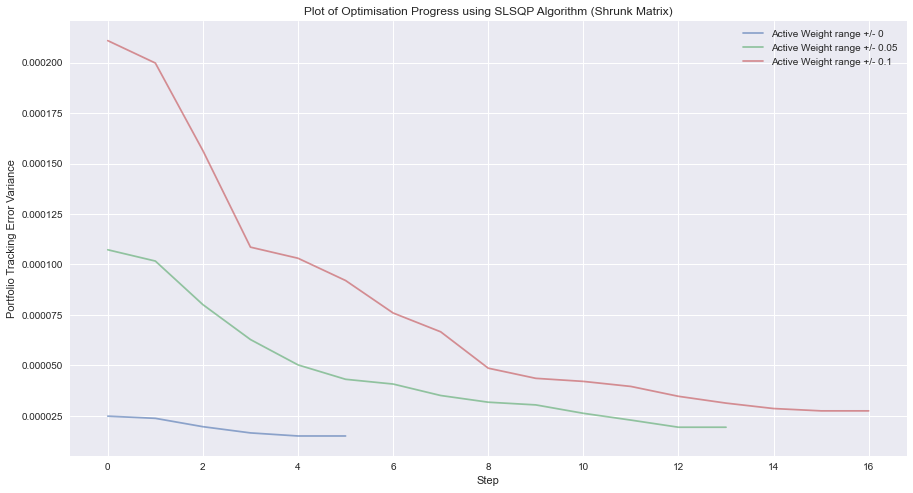

In [70]:
# Assuming history_weights is your list of lists
plt.figure(figsize=(15, 8))  # Increase size of figure as needed
plt.title('Plot of Optimisation Progress using SLSQP Algorithm (Shrunk Matrix)')
plt.xlabel('Step')
plt.ylabel('Portfolio Tracking Error Variance')

for i, sublist in enumerate(iter_obj_hist):
    plt.plot(range(len(sublist)), sublist, alpha=0.6, label='Active Weight range +/- ' + str(x_weight_bounds[i]))
    
plt.legend()
plt.show()



In [72]:
for i, weights in enumerate(active_weights_lst):

    #Derived stock weights for our portfolio from scipy minimise on estimated covariance. 
    tracking_error_variance = weights.T @ shrink_cov @ weights

    print("Resulting minimised tracking error variance for " + str(x_weight_bounds[i]) + " is: " + "{:.6f}".format(tracking_error_variance))


Resulting minimised tracking error variance for 0 is: 0.000015
Resulting minimised tracking error variance for 0.05 is: 0.000019
Resulting minimised tracking error variance for 0.1 is: 0.000027


**SLSQP for a Convex Objective Function**

Surprisingly even after shrinking the covariance matrix the SLSQP algorithm is susceptible to changes in the starting weight vector. A potential reason for this would be the presence of constraints, the different starting points may be close to violating one or more constraints at initialization leading to different constraint statisfaction patterns as the gradient based algorithm proceeds. This would result in the algorithm converging to different feasible solutions despite it now being a convex optimisation problem.

For the purposes of portfolio optimisation this presents potential future issues for the portfolio manager as constraints and initial points will change regularly due to rebalancing and changes in strategy.

**ECOS and OSQP for a Convex Objective Function**

Below we implement the ECOS and OSQP algorithms using the shrunk covariance matrix. Since both algorithms use a form of the Lagrangrian function to update the slack and dual variable to maintain feasibility we should not see the same starting point issue as we did for SLSQP:

In [73]:
#USING cvxpy and estimated covariance matrix
# Define the optimization variable
x = cp.Variable(x.shape[0])
# Define the objective function
objective = cp.quad_form(x, shrink_cov)

# Define the constraints
constraint_one_cvxpy = x.T @ alpha - g >= 0
constraint_two_cvxpy = cp.sum(x) == 0
constraint_three_cvxpy = -x + (c * ones - bench_weights_array) >= 0
constraint_four_cvxpy = x.T + bench_weights_array >= 0

In [74]:
for i,initial_x in enumerate(x_list):
    print("Solving for " + str(x_weight_bounds[i]))
    print("")
    for solver in solvers:
        problem = cp.Problem(cp.Minimize(objective),
                         [constraint_one_cvxpy, constraint_two_cvxpy, constraint_three_cvxpy, constraint_four_cvxpy])
        problem.solve(solver=solver)

        print("Solver:", solver)
        active_weights = x.value
        portfolio_weights = pd.DataFrame(sp_weights['% Wgt'] + active_weights,columns=['% Wgt'])
        portfolio_weights['% Wgt'] = round(portfolio_weights['% Wgt'], 4)
        tracking_error_variance = active_weights.T @ shrink_cov @ active_weights
        print(portfolio_weights)
        print("Resulting minimised tracking error variance is: " + "{:.6f}".format(tracking_error_variance))
        print("\n")


Solving for 0

Solver: ECOS
            % Wgt
Ticker           
AAPL US  0.089900
MSFT US  0.092800
AMZN US  0.043200
NVDA US  0.032300
GOOGL US 0.037800
...           ...
CB US    0.006000
SCHW US  0.000000
DUK US   0.006000
SO US    0.005600
TGT US   0.000000

[98 rows x 1 columns]
Resulting minimised tracking error variance is: 0.000012


Solver: OSQP
            % Wgt
Ticker           
AAPL US  0.089900
MSFT US  0.092800
AMZN US  0.043200
NVDA US  0.032300
GOOGL US 0.037800
...           ...
CB US    0.006000
SCHW US  0.000000
DUK US   0.006000
SO US    0.005600
TGT US   0.000000

[98 rows x 1 columns]
Resulting minimised tracking error variance is: 0.000012


Solving for 0.05

Solver: ECOS
            % Wgt
Ticker           
AAPL US  0.089900
MSFT US  0.092800
AMZN US  0.043200
NVDA US  0.032300
GOOGL US 0.037800
...           ...
CB US    0.006000
SCHW US  0.000000
DUK US   0.006000
SO US    0.005600
TGT US   0.000000

[98 rows x 1 columns]
Resulting minimised tracking error vari

Both the ECOS and OSQP algorithms are able to find the global minimum and result in the same active portfolio weights across starting points. The end result is zero tracking error variance to the index and a large share of the active weights going to large cap technology stocks. This portfolio composition makes sense in the context of our optimisation problem as these companies have rallied to start 2023 and represent the largest component of variance in the S&P500.

Although both algorithms are robust to changes in starting weights and find the global minimum, the OSQP algorithm is specifically designed for large scale quadratic programming problems. This means that as the universe of instruments becomes larger the ECOS method's performance may drop off relative to the OSQP algorithm, therefore OSQP seems to be a safe and robust algorithm to use for portfolio optimisation purposes.

To conclude we have shown the importance of convexity in the objective function when performing portfolio optimisation. For a large universe of stocks relative to data points the covariance matrix can be singular, resulting in poor optmisation results. The method of covariance matrix shrinkage detailed by Ledoit and Wolfe ensures the covariance matrix is non-singular and allows for convex optimisation methods to be used. We have shown that the use of constrained gradient based methods such as the SLSQP algorithm embedded in the SciPy package can lead to spurious results despite convexity in the objective function, therefore we recommend a more robust method such as OSQP which implements operator splitting methods on the augmented lagrangian function to ensure convergence and feasibility.  